In [88]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import data_tools
import xarray as xr
import pandas as pd
import datetime

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline

In [86]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [98]:
SC = data_tools.get_chs_tides('obs', 'Sandy Cove', '2017-11-30 00:05:00', '2018-01-08 23:54:00')

In [4]:
import os
HINDCAST_PATH = '/results/SalishSea/nowcast-green/'

In [99]:
SC.shape

(56752,)

In [206]:
list_of_model_ssh = np.array([])
for n in range(56752):
    date = pd.to_datetime(SC.index[n])
    if ((date.hour == 0) & (date.minute < 5)):
        before = (datetime.datetime(year = date.year, month = date.month, day = date.day, 
                           hour = (23), minute = 55) - datetime.timedelta(days=1))
    elif date.minute < 5:
        before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                           hour = date.hour-1, minute = 55)
    elif date.minute%10 < 5:
        before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                           hour = (date.hour), minute = 10*(date.minute//10) - 5)
    else:
        before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                           hour = (date.hour), minute = 10*(date.minute//10) + 5)  
    delta = (date - before).seconds / 600
    after = before + datetime.timedelta(minutes = 10)
    subdir = before.strftime('%d%b%y').lower()
    file = nc.Dataset(os.path.join(HINDCAST_PATH, subdir, 'SandyCove.nc'))
    subdir2 = after.strftime('%d%b%y').lower()
    file2 = nc.Dataset(os.path.join(HINDCAST_PATH, subdir2, 'SandyCove.nc'))
    corr = ((1-delta) * f[f.datetimes == before]['corr'].values[0] + 
           delta * f[f.datetimes == after]['corr'].values[0])
    s_val = ((1-delta) * file.variables['sossheig'][before.hour*6 + before.minute//10] + 
           delta*file2.variables['sossheig'][after.hour*6 + after.minute//10]) + corr + 3.09
    list_of_model_ssh = np.append(list_of_model_ssh, s_val)

In [103]:
from matplotlib.colors import LogNorm

bias =  0.0233940904601
RMSE = 0.180978548222
Willmott = 0.992864449515


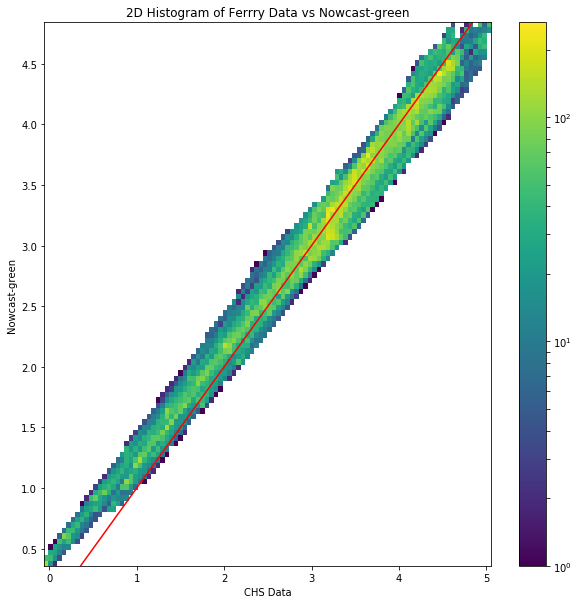

In [207]:
fig, ax = plt.subplots(figsize = (10,10))
c, xedge, yedge, im = ax.hist2d(SC.values, 
                                list_of_model_ssh, bins = 100, norm=LogNorm())
im
fig.colorbar(im, ax=ax)
ax.set_xlabel('CHS Data')
ax.set_ylabel('Nowcast-green')
ax.set_title('2D Histogram of Ferrry Data vs Nowcast-green')
ax.plot(np.arange(-1,6),np.arange(-1, 6), 'r')
obs = SC.values
print('bias =  ' + str(-np.mean(obs) + np.mean(list_of_model_ssh)))
print('RMSE = ' + str(np.sqrt(np.sum(((list_of_model_ssh) - obs)**2) / len(list_of_model_ssh))))
xbar = np.mean(obs)
print('Willmott = ' + str(1-(np.sum(((list_of_model_ssh) - obs)**2)  / 
                             np.sum((np.abs((list_of_model_ssh) - xbar) 
                                     + np.abs(obs - xbar))**2))))

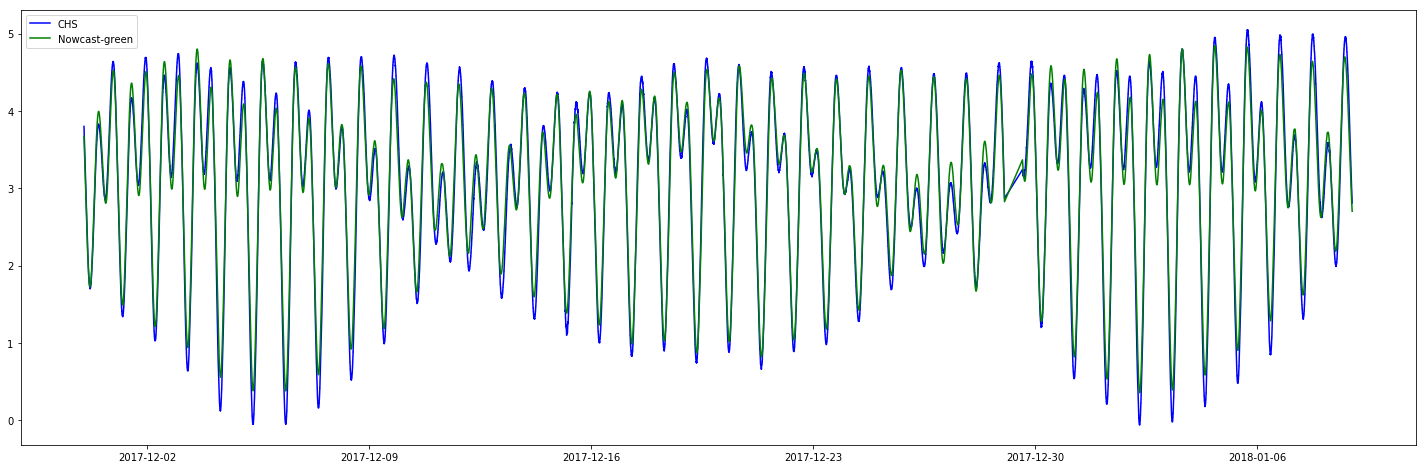

In [208]:
fig, ax = plt.subplots(figsize = (25,8))
ax.plot(SC.index.values, SC.values, 'b', label = 'CHS')
ax.plot(SC.index.values, list_of_model_ssh, 'g', label = 'Nowcast-green')
ax.legend()

/home/vdo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/vdo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


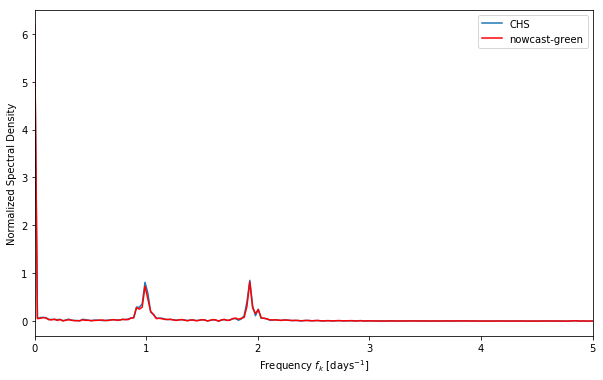

In [209]:
# Spectral density of the HRDPS Sandheads hourly wind record
rate = 1/(24 * 60)
n = len(SC.values)
f = np.linspace(0, 1/(2*rate), n/2)
C = np.fft.fft(SC.values)
C_norm = 2/n * np.abs(C[:n/2])

# Plot spectral density periodigram
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(f, C_norm, label = 'CHS')
ax.set_xlim([0, 5])
ax.set_xlabel('Frequency $f_k$ [days$^{-1}$]')
ax.set_ylabel('Normalized Spectral Density')

rate = 1/(24 * 60)
n = len(list_of_model_ssh)
f = np.linspace(0, 1/(2*rate), n/2)
C = np.fft.fft(list_of_model_ssh)
C_norm = 2/n * np.abs(C[:n/2])

ax.plot(f, C_norm, 'r', label = 'nowcast-green')
ax.legend()

In [147]:
f = pd.read_csv('/home/sallen/MEOPAR/ANALYSIS/analysis-storm-surges/notebooks/tide_analysis_scripts/Sandy Cove_tidal_prediction_01-Jan-2013_31-Dec-2020.csv', 
      header =3 , )

In [181]:
list_of_datetimes = np.array([])
for n in range(258335, 264244):
    dt = datetime.datetime.strptime(f['time '][n][:-1], '%d-%b-%Y %H:%M:%S')
    list_of_datetimes = np.append(list_of_datetimes, dt)

In [185]:
f = f[258335:264244]

In [189]:
f = f.assign(datetimes = list_of_datetimes)

In [198]:
f = f.assign(corr = f[' pred_noshallow '] - f[' pred_8 '])